In [51]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from typing import NamedTuple, Tuple
import numpy.typing as npt
from tqdm import tqdm
import random

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

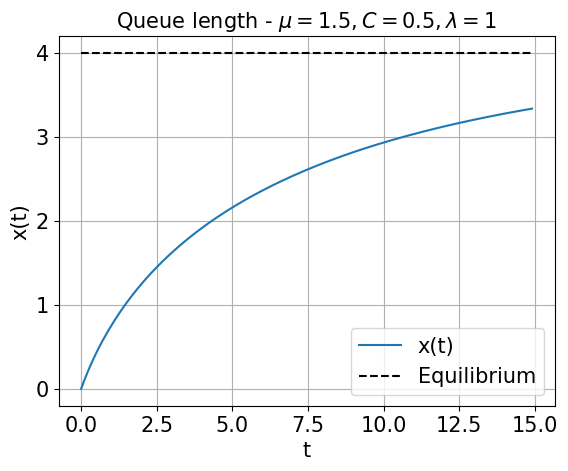

In [88]:
C = 1/2
MU = 1.5
LMBD = 1
NUM_POINTS = 150 
DELTA = 0.1 

class Parameters(NamedTuple):
    C: float
    MU: float
    LMBD: float
    
    @property
    def stationary_point(self) -> float: return LMBD / (C * (MU - LMBD))

def f(t, y, p: Parameters):
    """this is the rhs of the ODE to integrate, i.e. dy/dt=f(y,t)"""
    return -p.MU * p.C * y / (1 + p.C * y) + p.LMBD


def generate_data(x0: float, num_points: int, delta: float, parameters: Parameters) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    y0 = [x0]           # initial value y0=y(t0)
    t0 = 0             # integration limits for t: start at t0=0
    tf = 150 * delta   # and finish at tf=10
    t_eval = np.arange(t0, tf, delta)
    sol = solve_ivp(fun=lambda t,y: f(t, y, parameters), t_span=[t0, tf], y0=y0, t_eval=t_eval)  # computation of Solution 
    return sol.t, sol.y[0]

params = Parameters(C, MU, LMBD)
t, x = generate_data(0, NUM_POINTS, DELTA, params)

plt.plot(t, x, label='x(t)')
plt.plot(t, np.ones_like(t) * params.stationary_point, 'k--', label='Equilibrium')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('x(t)')
plt.title('Queue length - $\mu=' + str(MU) + f', C={C}, \\lambda={LMBD}$')
plt.show()

In [108]:

## PREPARE DATA

x_train = torch.tensor(x[:50][np.newaxis, ...], dtype=torch.float32)
x_test = torch.tensor(x[50:][np.newaxis, ...], dtype=torch.float32)


def normalize(x, x_min, x_max):
    return (x - x_min) / (x_max - x_min)


x_min, x_max = 0, 5
x_train = normalize(x_train, x_min, x_max)
x_test = normalize(x_test, x_min, x_max)

x_train = torch.vstack((x_train[0,:-1], x_train[0, 1:])).T
x_test = torch.vstack((x_test[0,:-1], x_test[0, 1:])).T



In [120]:
## Network definition

class Network(nn.Module):
    def __init__(self, hidden_size: int = 16):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(1, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 1))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)


[Epoch 99] Avg loss: 5.675683212302829e-07 - Validation loss: 0.02733422815799713: 100%|██████████| 100/100 [00:00<00:00, 167.56it/s] 


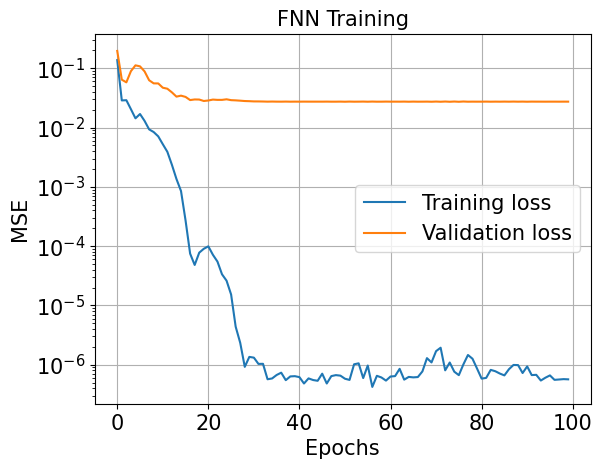

In [125]:
network = Network()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-2)

EPOCHS = 100
BATCH_SIZE = 16
trange = tqdm(range(EPOCHS))

rand_idxs = torch.randperm(x_train.size()[0])
data_batches = torch.utils.data.BatchSampler(x_train[rand_idxs], BATCH_SIZE, False)
random_batches = list(data_batches)

training_loss = []
validation_loss = []

for epoch in trange:
    random.shuffle(random_batches)
    losses = []
    for batch in random_batches:
        batch = torch.stack(batch, 0)
        out = network(batch[:, 0].unsqueeze(-1))
        loss = nn.MSELoss()(out, batch[:, 1].unsqueeze(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    # Compute validation loss
    with torch.no_grad():
        out_val = network(x_test[:,0].unsqueeze(-1))
        loss_val = nn.MSELoss()(out_val, x_test[:,1].unsqueeze(-1))
    trange.set_description(f'[Epoch {epoch}] Avg loss: {np.mean(losses)} - Validation loss: {loss_val}')
    
    
    training_loss.append(np.mean(losses))
    validation_loss.append(loss_val)

plt.plot(range(EPOCHS), training_loss, label='Training loss')
plt.plot(range(EPOCHS), validation_loss, label='Validation loss')
plt.grid()
plt.legend()
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('FNN Training')
plt.savefig('figures/fnn_training.png')

Text(0.5, 1.0, 'Generated trajectory vs true trajectory')

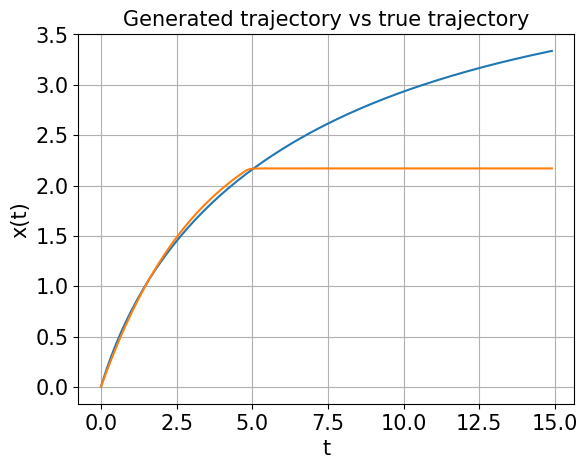

In [126]:
# Generate predicted trajectory and compare with true one

x_generated = [0]

x_t = torch.tensor([0], dtype=torch.float32)
for step in range(NUM_POINTS-1):
    x_tp1 = network(normalize(x_t, x_min, x_max))
    
    x_tp1 = x_tp1.item() * (x_max - x_min) + x_min
    
    x_generated.append(x_tp1)
    
    
    x_t = torch.tensor([x_tp1], dtype=torch.float32)
    
plt.plot(t, x)
plt.plot(t, x_generated)
plt.xlabel('t')
plt.ylabel('x(t)')
plt.grid()
plt.title('Generated trajectory vs true trajectory')
    

In [128]:
x_test

tensor([[0.4320, 0.4364],
        [0.4364, 0.4407],
        [0.4407, 0.4449],
        [0.4449, 0.4491],
        [0.4491, 0.4532],
        [0.4532, 0.4572],
        [0.4572, 0.4611],
        [0.4611, 0.4650],
        [0.4650, 0.4689],
        [0.4689, 0.4726],
        [0.4726, 0.4764],
        [0.4764, 0.4800],
        [0.4800, 0.4836],
        [0.4836, 0.4872],
        [0.4872, 0.4907],
        [0.4907, 0.4941],
        [0.4941, 0.4975],
        [0.4975, 0.5009],
        [0.5009, 0.5042],
        [0.5042, 0.5074],
        [0.5074, 0.5106],
        [0.5106, 0.5138],
        [0.5138, 0.5169],
        [0.5169, 0.5200],
        [0.5200, 0.5230],
        [0.5230, 0.5260],
        [0.5260, 0.5289],
        [0.5289, 0.5318],
        [0.5318, 0.5347],
        [0.5347, 0.5375],
        [0.5375, 0.5403],
        [0.5403, 0.5431],
        [0.5431, 0.5458],
        [0.5458, 0.5484],
        [0.5484, 0.5511],
        [0.5511, 0.5537],
        [0.5537, 0.5562],
        [0.5562, 0.5588],
        [0.5